# **Total Kinetic Energy (TKE)**

## Parent (CMEMS) *vs* Child (SHYFEM)

This Jupyter notebook calculates the **Total Kinetic Energy (TKE)** from the **Child** ocean model simulation, computed with `SHYFEM` using **Daily** or **Hourly** boundary forcing.

The resulting TKE is then systematically compared to that of the **Parent** simulation, derived from **CMEMS** (Copernicus Marine Environment Monitoring Service) [Mediterranean Sea Analysis](https://data.marine.copernicus.eu/product/MEDSEA_ANALYSISFORECAST_PHY_006_013/description) products.

## 1. Define Parameters and File Paths

In [11]:
import numpy as np
from module_visu import *
import matplotlib.tri as tri
import geopandas as gpd
from shapely.geometry import Polygon, Point
from collections import defaultdict
from datetime import datetime, timedelta
import xarray as xr
import os
from scipy.spatial import ConvexHull
from scipy.interpolate import interpn

# ------------------------------------------------------------------------------
# 📂 FILE PATHS

# Experiment Label
label_exp = "hourly" # Options : "hourly", "daily+"

# Experiment Path
# path_exp = f"/work/cmcc/rv29524/simulations/shyfem/civitavecchia/{label_exp}_202409"
path_exp = f"../hourly_202409"
print(f"|--> Experiment ID : {os.path.basename(path_exp)}")

# Child Files
files_child = [
    f"{path_exp}/cv.ous.nc",
]

# Parent Files (with hourly frequency, downloaded from CMEMS database)
files_parent = {
    f"./indata_hourly_2024/ocean/YYYYMMDD_U_smallSOL.nc"    : "uo",
    f"./indata_hourly_2024/ocean/YYYYMMDD_V_smallSOL.nc"    : "vo",
}

# Output Paths
path_figure = {
    "root": "./figures",
    "parent": "./figures/parent",
    "child": "./figures/child",
    "comparison": "./figures/comparison"
}
def create_directories(paths):
    """Creates required directories if they don't exist."""
    for key, directory in paths.items():
        try:
            os.makedirs(directory, exist_ok=True)
            print(f"✅ Created or verified: {key} → {directory}")
        except OSError as e:
            print(f"❌ Failed to create {key} → {directory}: {e}")
create_directories(path_figure)

# ------------------------------------------------------------------------------
# 📅 GET TIME RANGE FROM SIMULATION DATASET

# Get min/max timestamp from simulation dataset
with xr.open_dataset(os.path.join(path_exp,files_child[0])) as ds:
    start_date_str = str(ds["time"].values[0])[:19]
    end_date_str = str(ds["time"].values[-1])[:19]
    nhours = len(ds["time"].values)

# Convert date strings to datetime objects
start_date = datetime.strptime(start_date_str, "%Y-%m-%dT%H:%M:%S")
end_date   = datetime.strptime(end_date_str, "%Y-%m-%dT%H:%M:%S")

# Number of simulation days
ndays = (end_date-start_date).days
day_indices = [str(start_date + i*timedelta(days=1))[:10] for i in list(range(ndays))]

print(f"\n📅 TIME RANGE:")
print(f"    |--> Start Date : {start_date_str}")
print(f"    |--> End Date   : {end_date_str}")
print(f"    |--> # of simulation days (including spin-up) : {ndays}")


|--> Experiment ID : hourly_202409
✅ Created or verified: root → ./figures
✅ Created or verified: parent → ./figures/parent
✅ Created or verified: child → ./figures/child
✅ Created or verified: comparison → ./figures/comparison

📅 TIME RANGE:
    |--> Start Date : 2024-09-15T02:00:00
    |--> End Date   : 2024-11-14T01:00:00
    |--> # of simulation days (including spin-up) : 59


## 2. Process Child Data

### Load Child Grid

In [2]:
# Load Grid
print(f"📌 Reading child grid:")
with xr.open_dataset(files_child[0]) as ds:
    lon_child = ds["longitude"].values
    lat_child = ds["latitude"].values
    depth_child = ds["level"].values
    # depth_child = read_netcdf_var(ds,"level").values#[k_child]
    ielems = ds["element_index"].values - 1 # zero-based
    triangles = tri.Triangulation(lon_child, lat_child, ielems)
print(f"    |--> # of nodes           : {len(lon_child)}")
print(f"    |--> # of elements        : {len(ielems)}")
print(f"    |--> # of vertical levels : {len(depth_child)}")

# Define Grid Convex Hull
# Count occurrences of each edge
edge_count = defaultdict(int)
for tri_nodes in triangles.triangles:
    edges = [
        tuple(sorted([tri_nodes[0], tri_nodes[1]])),
        tuple(sorted([tri_nodes[1], tri_nodes[2]])),
        tuple(sorted([tri_nodes[2], tri_nodes[0]]))
    ]
    for edge in edges:
        edge_count[edge] += 1

# Boundary edges are those with count == 1
boundary_edges = [edge for edge, count in edge_count.items() if count == 1]

# Edge nodes are the unique nodes in those edges
edge_nodes = set()
for edge in boundary_edges:
    edge_nodes.update(edge)
edge_nodes = list(edge_nodes)
edge_points = np.vstack((lon_child[edge_nodes], lat_child[edge_nodes])).T

# Compute the convex hull
hull = ConvexHull(edge_points)
ordered_points = edge_points[hull.vertices]
# Create a polygon
grid_polygon = Polygon(ordered_points)

📌 Reading child grid:
    |--> # of nodes           : 32045
    |--> # of elements        : 62701
    |--> # of vertical levels : 33


### Load Child Datasets

In [3]:
# Load Child Datasets (hourly output)
for file in files_child :
    print(f"\n📌 Reading Model File : {os.path.basename(file)}")
    with xr.open_dataset(file) as ds :
        if file.endswith("ous.nc") :
            uvel_child = read_netcdf_var(ds,"u_velocity").values
            vvel_child = read_netcdf_var(ds,"v_velocity").values
time_child = read_netcdf_var(ds,"time").values
nlevel_ous = uvel_child.shape[-1]


📌 Reading Model File : cv.ous.nc
  |--> Reading variable u_velocity(1440, 32045, 33) done ✓ 
  |--> Reading variable v_velocity(1440, 32045, 33) done ✓ 
  |--> Reading variable time(1440,) done ✓ 


### Compute Grid Weight Coefficients

For weighting the volume integral for the computation of the Total Kinetic Energy (TKE).

In [4]:
def grid_weight_coefficient(x, y=None) :

    # Initialize Array
    grid_weight = np.zeros(len(x))

    # Horizontal Grid
    if y is not None :
        for node in range(len(x)):
            xc = x - x[node]
            yc = y - y[node]
            radial_distance = np.sqrt(xc**2. + yc**2.)
            grid_weight[node] = radial_distance[radial_distance != 0].min()

    # Vertical Grid
    else :
        grid_weight = np.diff(x)
        grid_weight = np.append(grid_weight, grid_weight[-1])

    # Normalize
    grid_weight = grid_weight / grid_weight.max()

    return grid_weight

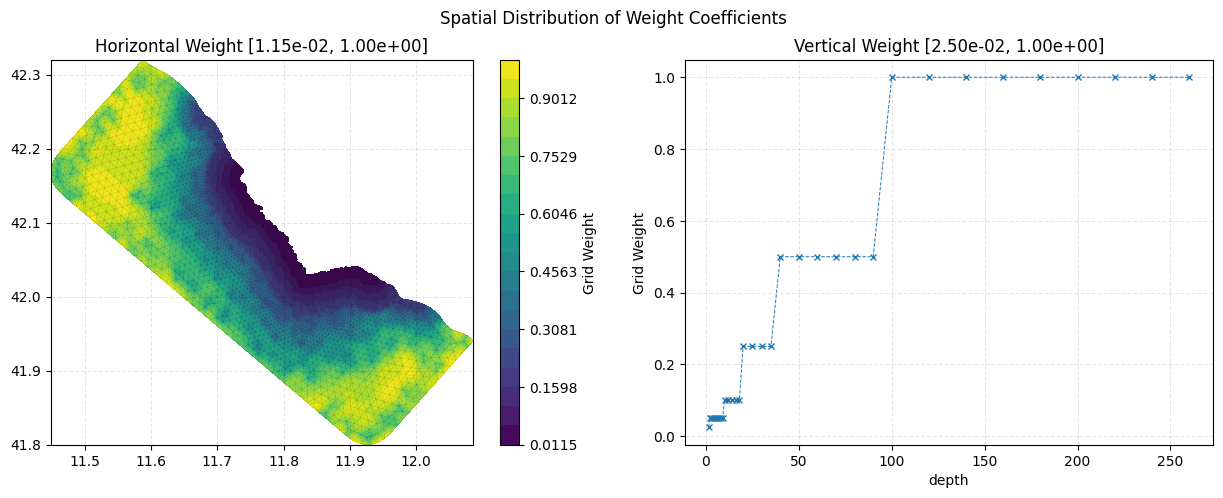

In [5]:
# Compute Horizontal Grid Weight
horizontal_grid_weight = grid_weight_coefficient(lon_child, lat_child)

# Compute Vertical Grid Weight
vertical_grid_weight   = grid_weight_coefficient(depth_child)

# Visualize Grid Weight Coefficients
# Horizontal
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
levels = np.linspace(horizontal_grid_weight.min(), horizontal_grid_weight.max(), 21)
plt.suptitle(f"Spatial Distribution of Weight Coefficients")
axs[0].set_title(f"Horizontal Weight [{horizontal_grid_weight.min():.2e}, {horizontal_grid_weight.max():.2e}]")
contour = axs[0].tricontourf(triangles, horizontal_grid_weight, levels=levels)
axs[0].triplot(triangles, lw=0.3, alpha=0.2, color='k')
axs[0].grid(ls='--', c='k', alpha=0.1)
cbar = fig.colorbar(contour, ax=axs[0])
cbar.set_label("Grid Weight")
# Vertical
axs[1].set_title(f"Vertical Weight [{vertical_grid_weight.min():.2e}, {vertical_grid_weight.max():.2e}]")
axs[1].plot(depth_child, vertical_grid_weight, "--", c="tab:blue", lw=0.7)
axs[1].plot(depth_child, vertical_grid_weight, "x", ms=4.0, c="tab:blue", lw=0.7)
axs[1].set_xlabel("depth")
axs[1].set_ylabel("Grid Weight")
axs[1].grid(ls='--', c='k', alpha=0.1)
plt.savefig(os.path.join(path_figure["root"], "grid_weight_coefficients.png"))
plt.close()

### Compute Child TKE

In [6]:
print(f"\n📌Computing Total Kinetic Energy (Child)...")
# Compute 3D TKE
tke_child_3d = 0.5 * (uvel_child**2 + vvel_child**2)

# Volume integral
# Horizontal
print(f"\t|---> Computing Weighted Average (Horizontal)...")
tke_child_2d = np.average(tke_child_3d, weights=horizontal_grid_weight, axis=1)
# Vertical
print(f"\t|---> Computing Weighted Average (Vertical)...")
tke_child    = np.average(tke_child_2d, weights=vertical_grid_weight  , axis=1)

del tke_child_3d, tke_child_2d


📌Computing Total Kinetic Energy (Child)...
	|---> Computing Weighted Average (Horizontal)...
	|---> Computing Weighted Average (Vertical)...


## 3. Process Parent Data

### Load Parent Datasets and Grid

In [12]:
# Load Data
for file_parent in files_parent.keys():
    print(f"\n📌 Reading Parent Files:")
    itime=0
    for time in day_indices:
        file = file_parent.replace("YYYYMMDD",f"{time[:4]}{time[5:7]}{time[8:10]}")
        var_name = files_parent[file_parent]
        print(f"\t|--> {os.path.basename(file)}")

        with xr.open_dataset(file) as ds:
            if var_name == "uo":
                uvel_parent = ds[var_name] if itime==0 else xr.concat([uvel_parent, ds[var_name]], dim="time")
                time_parent = ds["time"] if itime==0 else xr.concat([time_parent, ds["time"]], dim="time")
            elif var_name == "vo":
                vvel_parent = ds[var_name] if itime==0 else xr.concat([vvel_parent, ds[var_name]], dim="time")
        itime+=1

# Parent Grid
lon_parent = ds[var_name]["lon"].values#[0]
lat_parent = ds[var_name]["lat"].values#.T[0]
nx_parent, ny_parent = len(lon_parent), len(lat_parent)
lon2d_parent, lat2d_parent = np.meshgrid(lon_parent, lat_parent)

# Define parent grid points inside Child Convex Hull
inside_points = np.array([[grid_polygon.contains(Point((x,y))) for x in lon_parent] for y in lat_parent])

# Correct time shift (to ZULU time)
time_parent = np.array([t - np.timedelta64(30,'m') for t in time_parent.values])

# Extract vertical range (parent's data contained in child's depth range)
depth_parent = xr.open_dataset(file)["depth"].values
uvel_parent = uvel_parent[:,depth_parent<=depth_child.max(),...]
vvel_parent = vvel_parent[:,depth_parent<=depth_child.max(),...]
depth_parent = depth_parent[depth_parent<=depth_child.max()]


📌 Reading Parent Files:
	|--> 20240915_U_smallSOL.nc
	|--> 20240916_U_smallSOL.nc
	|--> 20240917_U_smallSOL.nc
	|--> 20240918_U_smallSOL.nc
	|--> 20240919_U_smallSOL.nc
	|--> 20240920_U_smallSOL.nc
	|--> 20240921_U_smallSOL.nc
	|--> 20240922_U_smallSOL.nc
	|--> 20240923_U_smallSOL.nc
	|--> 20240924_U_smallSOL.nc
	|--> 20240925_U_smallSOL.nc
	|--> 20240926_U_smallSOL.nc
	|--> 20240927_U_smallSOL.nc
	|--> 20240928_U_smallSOL.nc
	|--> 20240929_U_smallSOL.nc
	|--> 20240930_U_smallSOL.nc
	|--> 20241001_U_smallSOL.nc
	|--> 20241002_U_smallSOL.nc
	|--> 20241003_U_smallSOL.nc
	|--> 20241004_U_smallSOL.nc
	|--> 20241005_U_smallSOL.nc
	|--> 20241006_U_smallSOL.nc
	|--> 20241007_U_smallSOL.nc
	|--> 20241008_U_smallSOL.nc
	|--> 20241009_U_smallSOL.nc
	|--> 20241010_U_smallSOL.nc
	|--> 20241011_U_smallSOL.nc
	|--> 20241012_U_smallSOL.nc
	|--> 20241013_U_smallSOL.nc
	|--> 20241014_U_smallSOL.nc
	|--> 20241015_U_smallSOL.nc
	|--> 20241016_U_smallSOL.nc
	|--> 20241017_U_smallSOL.nc
	|--> 20241018_U_s

### Compute Parent TKE
Parent TKE is computed on the child's grid.

In [8]:
print(f"\n📌 Computing Total Kinetic Energy (Parent)...")

# Compute 3D TKE
tke_parent_3d = 0.5 * (uvel_parent**2 + vvel_parent**2).values

# Interpolate TKE to child grid
print(f"\t|--> Interpolating Parent Data to Child Grid...")

# Force Land points to zero (needed for interpolation)
tke_parent_3d = xr.where(np.isnan(tke_parent_3d), 0, tke_parent_3d)

# Interpolate to child grid
tke_parent_interp = np.zeros((len(time_parent), len(depth_parent), len(lon_child)))

# Define source and destination grids
grid_src = (lat_parent, lon_parent)
grid_dst = (lat_child, lon_child)

# Interpolate to child grid
ntime = len(time_parent)
for itime in range(ntime):
    print(f"\t\t{100.*float(itime)/float(ntime):.2f}%", end='\r')
    for level in range(len(depth_parent)):
        tke_parent_interp[itime, level, ...] = interpn(grid_src, tke_parent_3d[itime, level, ...], grid_dst, method='linear')

# Volume integral
# Horizontal
print(f"\t|---> Computing Weighted Average (Horizontal)...")
tke_parent_2d = np.average(tke_parent_interp, weights=horizontal_grid_weight, axis=2)
# Vertical
print(f"\t|---> Computing Weighted Average (Vertical)...")
parent_grid_weight = grid_weight_coefficient(depth_parent)
mask = ~np.isnan(tke_parent_2d[-1])
tke_parent_2d = tke_parent_2d[..., mask]
parent_grid_weight = parent_grid_weight[mask]
tke_parent = np.average(tke_parent_2d, weights=parent_grid_weight, axis=1)

del tke_parent_3d, tke_parent_2d


📌 Computing Total Kinetic Energy (Parent)...
	|--> Interpolating Parent Data to Child Grid...
	|---> Computing Weighted Average (Horizontal)...
	|---> Computing Weighted Average (Vertical)...


## 4. Extract Time Period for Comparison

In [9]:
# Identify min/max intersection between simulation and observation data
time_min = np.max((time_parent.min(), time_child.min()))
time_max = np.min((time_parent.max(), time_child.max()))
print(f"\n📌 Comparing data between {str(time_min)[:19]} <---> {str(time_max)[:19]}")

# Extract Data in intersection time period
# Parent
if ((time_parent.min() < time_min) or (time_parent.max() > time_max)) :
    tke_parent = tke_parent[(time_parent>=time_min) & (time_parent<=time_max)]
    time_parent = time_parent[(time_parent>=time_min) & (time_parent<=time_max)]
# Child
if ((time_child.min() < time_min) or (time_child.max() > time_max)) :
    tke_child = tke_child[(time_child>=time_min) & (time_child<=time_max)]
    time_child = time_child[(time_child>=time_min) & (time_child<=time_max)]
nhours = len(time_parent)


📌 Comparing data between 2024-09-15T02:00:00 <---> 2024-11-12T23:00:00


## 5. Plot TKE

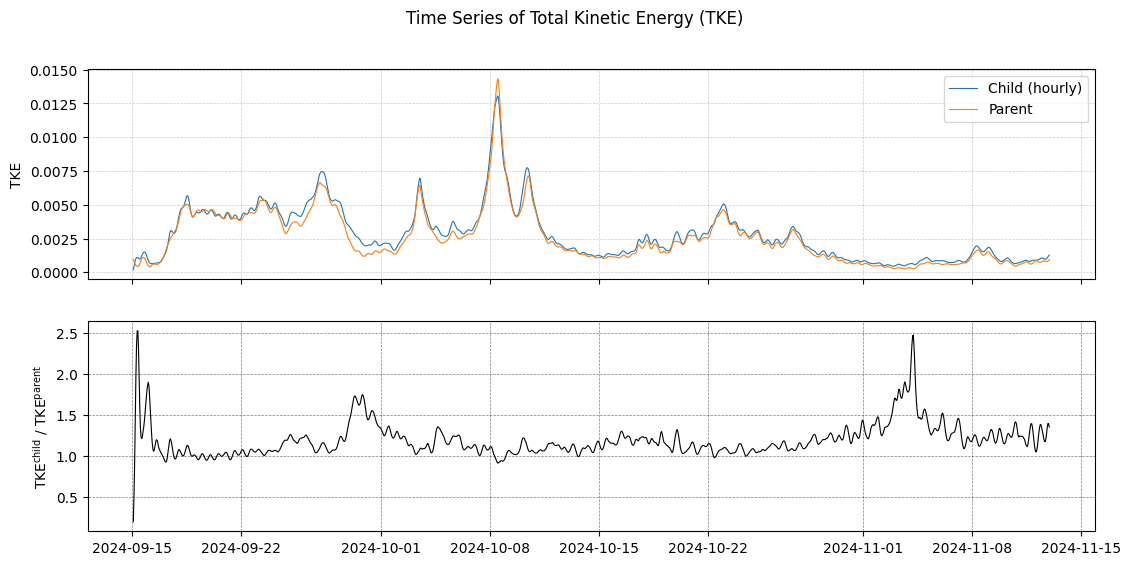

In [10]:
fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(13,6), sharex=True)
plt.suptitle(f"Time Series of Total Kinetic Energy (TKE)")

# Plot TKE
axs[0].plot(time_child , tke_child , lw=0.8, label=f"Child ({label_exp})")
axs[0].plot(time_parent, tke_parent, lw=0.8, label="Parent")
axs[0].set_ylabel("TKE")
axs[0].grid(lw=0.5, c="k", alpha=0.2, ls="--")
axs[0].legend()

# Plot TKE Ratio
axs[1].plot(time_child, tke_child/tke_parent, "k-", lw=0.8)
axs[1].set_ylabel(r"TKE$^\text{child}$ / TKE$^\text{parent}$")
axs[1].grid(lw=0.5, c="k", alpha=0.5, ls="--")
plt.savefig(os.path.join(path_figure["comparison"], "TKE_parent_vs_child.png"), dpi=300)
plt.show()
plt.close()